In [1]:
import igraph
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pynauty
from scipy.linalg import ishermitian
from scipy.sparse.csgraph import connected_components
from sympy.combinatorics import Permutation, PermutationGroup

from qlinks.model.spin1_xy_model_1d import Spin1XYModel
from utils import setup_igraph

np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", None)

# Spin-1 XY model

* Size of Hilbert space: $3^n$


|  $n$  | 2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  | 11  |
|:-----:|:--:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_H$ |  9  | 27  | 81  | 243 | 729 |2187 |6561 |19683|59049|177147|

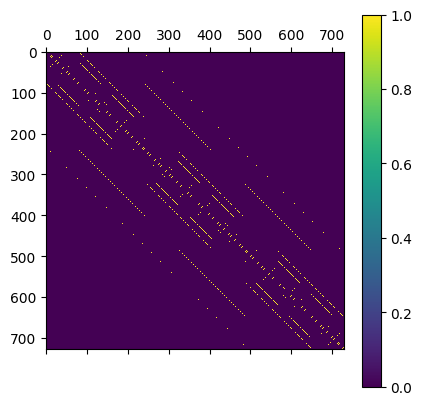

In [22]:
coup_j, coup_h, coup_d, coup_j3 = (1, 0, 0, 1)
model = Spin1XYModel(6, coup_j, coup_h, coup_d, coup_j3, periodic=False)
mat = model.hamiltonian.toarray()
assert ishermitian(mat)
evals, evecs = np.linalg.eigh(mat)

plt.matshow(mat)
plt.colorbar()

In [ ]:
plt.plot(evals, linestyle="--", marker="o")
plt.grid()

In [ ]:
model.basis.loc[np.array([179, 197, 185, 143, 203, 221, 227, 223, 209, 229, 235, 237, 155, 231, 157, 213, 77, 159, 79, 133, 53, 107, 71, 187, 125, 205, 149, 131, 211, 151])]

In [ ]:
model.parity

In [ ]:
np.allclose(model.parity @ model.kinetic_term + model.kinetic_term @ model.parity, 0, atol=1e-12)

In [ ]:
evecs_df = pd.DataFrame.from_dict(
    {
        "eval": evals,
        "kin": [(evec.T @ model.kinetic_term @ evec).item() for evec in evecs.T],
        "pot": [(evec.T @ model.potential_term @ evec).item() for evec in evecs.T],
        "pot2": [(evec.T @ model.potential_term2 @ evec).item() for evec in evecs.T],
        # "kin^2": [(evec.T @ model.kinetic_term @ model.kinetic_term @ evec).item() for evec in evecs.T],
        # "pot^2": [(evec.T @ model.potential_term @ model.potential_term @ evec).item() for evec in evecs.T],
    }
)
evecs_df[evecs_df["kin"].abs() < 1e-12]

In [ ]:
3 ** model.n - np.linalg.matrix_rank(model.kinetic_term.toarray())

In [ ]:
i = 73
plt.plot(evecs[:, i].T, linestyle="--", marker="o", color="red")
plt.grid()
np.where(evecs[:, i] < -1e-6)[0]

In [23]:
g = nx.from_scipy_sparse_array(model.kinetic_term)
ig = igraph.Graph.from_networkx(g)

ntg = pynauty.Graph(
    ig.vcount(),
    directed=True,
    adjacency_dict=nx.to_dict_of_lists(g),
)
aut_gp = pynauty.autgrp(ntg)[0]

perm_gp = PermutationGroup([Permutation(p) for p in aut_gp])

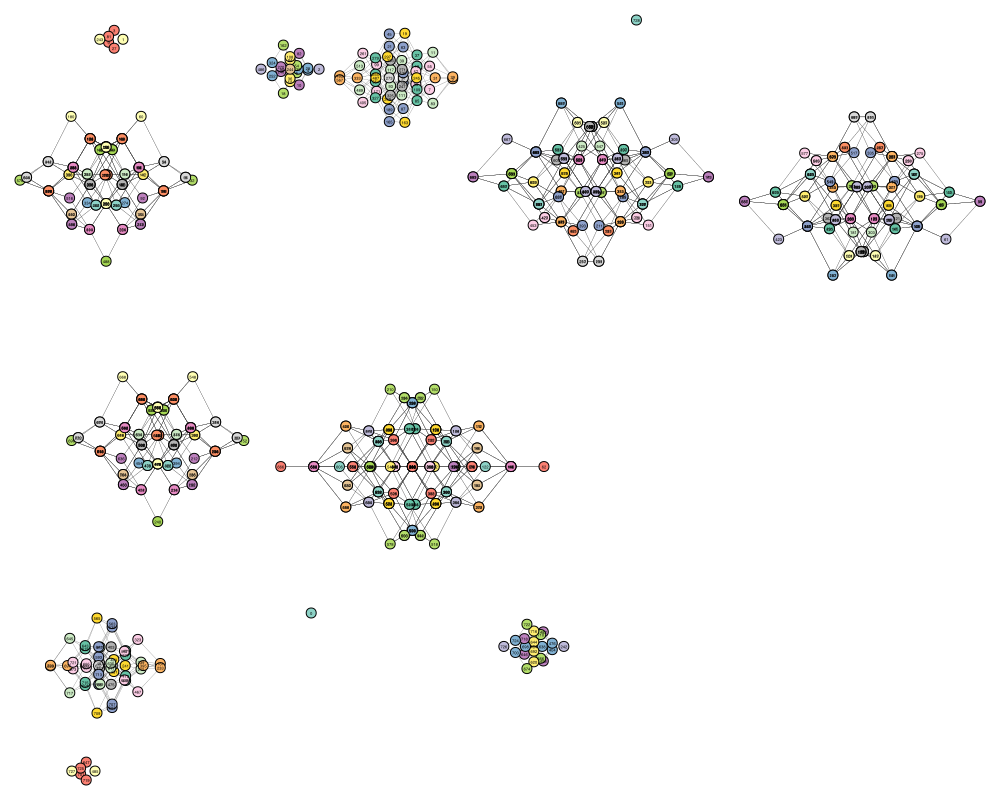

In [24]:
g = nx.from_scipy_sparse_array(model.kinetic_term)

highlight = [
    # np.where(np.abs(evecs[:, 231]) > 1e-6)[0],
]
# highlight = list(aut.degree_partition.values())
highlight = perm_gp.orbits()
# highlight = list(nx.bipartite.sets(g))

# highlight_color = list(mcolors.TABLEAU_COLORS.values())
# highlight_color = list(mcolors.CSS4_COLORS.values())
cmap = plt.get_cmap('Set3')
highlight_color = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
cmap = plt.get_cmap('Set2')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
highlight_color *= 2000
# highlight_color = [
#     "dimgray",
#     "whitesmoke",
#     "deepskyblue",
#     "yellowgreen",
#     "aqua",
#     "pink",
#     "tomato",
#     "royalblue",
#     "blueviolet",
#     "cornflowerblue",
#     "limegreen",
# ]

ig = setup_igraph(g, highlight, highlight_color)

degree = np.array(list(dict(g.degree).values()))
# (bipartite, types) = ig.is_bipartite(return_types=True)
# nodes = [int(n) for n in list(sub_sub_ig.vs["label"])]
# outer_boundary = list(nx.node_boundary(g, nodes))
# sub_ig = ig.induced_subgraph(np.append(nodes, outer_boundary))

# sub_ig = ig.induced_subgraph(np.where(degree == 8)[0])
# fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
igraph.plot(
    ig,
    # layout=ig.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    layout=ig.layout_mds(),
    vertex_size=10,
    vertex_label_size=4,
    # vertex_label_dist=1.5,
    edge_width=0.2,
    # edge_color="darkgray",
    # target="xy_graph_pbc_4.svg"
    bbox=(1000,800),
)

In [25]:
sub_components = ig.connected_components(mode="weak")

for i, c in enumerate(sub_components):
    mat = nx.to_numpy_array(ig.subgraph(c).to_networkx())
    # print(repr(mat))
    print(i, mat.shape[0], mat.shape[0] - np.linalg.matrix_rank(mat), nx.is_bipartite(ig.subgraph(c).to_networkx()))
    # print(np.diagonal(mat))

0 1 1 True
1 6 2 True
2 21 5 True
3 50 8 True
4 90 14 True
5 126 16 True
6 141 19 True
7 126 16 True
8 90 14 True
9 50 8 True
10 21 5 True
11 6 2 True
12 1 1 True


In [ ]:
sub_ig = ig.subgraph(sub_components[3])

igraph.plot(
    sub_ig,
    layout=sub_ig.layout_fruchterman_reingold(),
    # layout=sub_ig.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=18,
    vertex_label_size=8,
    # vertex_label_dist=1.5,
    edge_width=0.2,
    # edge_curved=0.1,
    # edge_color="darkgray",
    bbox=(200,300),
    # target="xy_graph_pbc_5_sz-2.svg"
)

In [ ]:
g2 = nx.to_numpy_array(sub_ig.to_networkx())
highlight = list(nx.bipartite.sets(nx.from_numpy_array(g2)))
g2 = nx.from_numpy_array(np.linalg.matrix_power(g2, 2))
ig2 = setup_igraph(g2, highlight, ["dimgray", "whitesmoke"])

igraph.plot(
    ig2,
    # layout=g2.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=24,
    vertex_label_size=12,
    # vertex_label_dist=1.5,
    edge_width=0.2,
    # edge_color="darkgray",
    bbox=(300,300),
    # target="bipartite_proj2.svg"
)

In [ ]:
two_step_mat = np.linalg.matrix_power(nx.to_numpy_array(sub_ig.to_networkx()), 2)

n_components, labels = connected_components(
    two_step_mat, directed=False, connection="weak", return_labels=True
)
for i in range(n_components):
    mask = (labels == i)
    sub_mat = two_step_mat[np.ix_(mask, mask)]
    print(sub_mat.shape[0], sub_mat.shape[0] - np.linalg.matrix_rank(sub_mat))

In [ ]:
mask = (labels == 0)
sub_mat = two_step_mat[np.ix_(mask, mask)]
np.linalg.eigh(sub_mat)[1]

In [ ]:
df = pd.read_csv("spin1_xy_scars.csv", usecols=["n", "periodic", "sz", "nullity"])

pd.pivot_table(
    df,
    index=["n", "periodic"],
    columns=["sz"],
    values="nullity",
    aggfunc="sum"
)